# BPE-Segmentation PFST

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from genparse.segmentation import (
    segmentation_pfst as construction,
    fmt,
    run_segmentation_test,
)
from IPython.display import HTML

In [3]:
contexts = {'a', 'b', 'c', 'ab', 'abc'}
alphabet = set('abc')

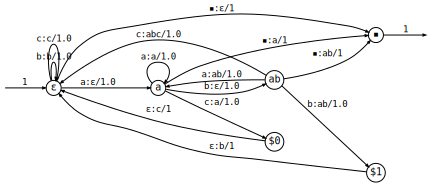

In [4]:
cc = construction(contexts, alphabet, canonical=1)
cc.graphviz(fmt_node=fmt)

In [5]:
test_strings = [
    'aba',
    'ab',
    #'aa',
    #'acab',
    #'abc',
    #'abcabc',
    #'abcab',
]

In [6]:
C = cc
for x in test_strings:
    display(HTML(f'<hr/><h3>{x}</h3>'))
    run_segmentation_test(C, x, contexts, verbose=2)


input: aba
✔ total weight: 1.0


✔ aba ('ab', 'a')



input: ab
✔ total weight: 1.0


✔ ab ('ab',)


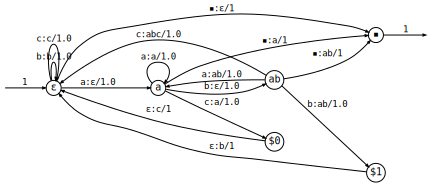

In [7]:
canonical = construction(contexts, alphabet, canonical=True)
canonical.graphviz(fmt_node=fmt)

In [8]:
for x in test_strings:
    display(HTML(f'<hr/><h3>{x}</h3>'))
    run_segmentation_test(canonical, x, contexts, verbose=1)


input: aba
✔ total weight: 1.0
✔ aba ('ab', 'a')



input: ab
✔ total weight: 1.0
✔ ab ('ab',)


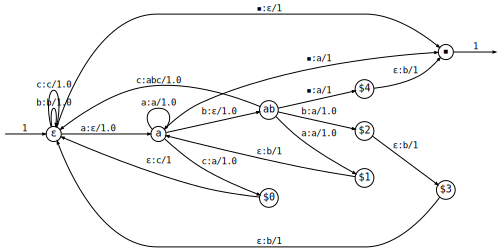

In [9]:
contexts = {'a', 'b', 'c', 'abc'}  # not prefix closed!
alphabet = set('abc')
cc = construction(contexts, alphabet, canonical=True)
cc.graphviz(fmt_node=fmt)

In [10]:
for x in test_strings:
    display(HTML(f'<hr/><h3>{x}</h3>'))
    run_segmentation_test(cc, x, contexts, verbose=1)


input: aba
✔ total weight: 1.0
✔ aba ('a', 'b', 'a')



input: ab
✔ total weight: 1.0
✔ ab ('a', 'b')
